### Calculate Q as residual
#### Calculate each term in the thermodynamics equation (unit:K/s)
#### for NCEP-NCAR Reanalysis (update:2018/11/26)

In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
import xesmf as xe
import xgcm

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from cartopy import config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs   #cartopy projection tool

### 1. Define derivative

In [2]:
def grid_setup(ds,pergrid):

    dlon = ds.lon[1] - ds.lon[0]; dlat = ds.lat[1] - ds.lat[0]
    lonh = ds.lon + dlon/2.0; lath = ds.lat + dlat/2.0
    if 'lon' in pergrid:
        ds['lonh'] = ('lonh',lonh) 
    else:
        ds['lonh'] = ('lonh',np.concatenate(([lonh.values[0]-dlon],lonh.values))) 
    ds['lath'] = ('lath',np.concatenate(([lath.values[0]-dlat],lath.values)))

def divergence(ds, u, v, periodic = ['lon']):
    
    if 'lon' in periodic:
        grid = xgcm.Grid(ds, coords={'lon': {'center': 'lon', 'right': 'lonh'},\
                                     'lat': {'center': 'lat', 'outer': 'lath'}}, periodic=True)
    else:
        grid = xgcm.Grid(ds, coords={'lon': {'center': 'lon', 'outer': 'lonh'},\
                                     'lat': {'center': 'lat', 'outer': 'lath'}}, periodic=False)

    dlon = ds.lon[1]-ds.lon[0]; dlat = ds.lat[1]-ds.lat[0]

    coslat = np.cos(np.deg2rad(ds.lat))
    coslath = np.cos(np.deg2rad(ds.lath))
    meterPdegree = 111000.0

    dlonm = dlon*meterPdegree; dlatm = dlat*meterPdegree

    # interpolate the quantities to edge of trapezoid and then compute derivatives

    uh = grid.interp(u,axis='lon',boundary='extend')
    vh = grid.interp(v,axis='lat',boundary='extend')
    dvdy = grid.diff(coslath*vh,axis='lat',boundary='extend')/dlatm  
    dudx = grid.diff(uh,axis='lon',boundary='extend')/dlonm
    return (dudx + dvdy)/coslat

### 2. Read-in Temperature + Temperature gradient

In [3]:
ingridsnippet = """ 
  SOURCES .NOAA .NCEP-NCAR .CDAS-1 .MONTHLY .Intrinsic .PressureLevel .temp
  T (Jan/ 1950) (Feb/ 2018) RANGEEDGES
  Y (90S) (90N) RANGEEDGES
  P (10) (1000) RANGEEDGES
  """
snip = ' '.join(ingridsnippet.split()).replace('/ ','%20').replace('(','%28').replace(')','%29').replace('[','%5B').replace(']','%5D').replace(' ','/')
tt_url = 'https://iridl.ldeo.columbia.edu/'+snip+'/dods'

In [4]:
# Temperature
tin = xr.open_dataset(tt_url,decode_times=False)
tin['T']=pd.date_range('1/1/1950', periods=tin.temp.shape[0], freq='M')
tin = tin.rename({'T':'time','X':'lon','Y':'lat'})
grid_setup(tin,['lon'])
tt=tin.temp

In [5]:
nt = tin.temp.shape[0]; yr = int(nt/12)
nz = tin.temp.shape[1]
ny = tin.temp.shape[2]
nx = tin.temp.shape[3]

In [6]:
### dT/dx
tt_extend = xr.concat([tt[:,:,:,-1], tt, tt[:,:,:,0]],'lon')
lon_extend = xr.concat([tt.lon[0]-2.5, tt.lon, tt.lon[-1]+2.5],'lon')

coslat = np.cos(np.deg2rad(tt.lat))
dTx = tt_extend.diff('lon').rolling(lon=2).mean().shift(lon=-1)
dx = coslat*111000*lon_extend.diff('lon').rolling(lon=2).mean().shift(lon=-1)
dTdx = dTx[:,:,:,0:-1]/dx[:,0:-1]

del tt_extend, lon_extend
import gc
gc.collect()

7

In [7]:
### dT/dy
#coslath = np.cos(np.deg2rad(tin.lath))
dTy = tt.diff('lat').rolling(lat=2).mean().shift(lat=-1)
dy = 111000*tt.lat.diff('lat').rolling(lat=2).mean().shift(lat=-1)

In [8]:
dTdy_temp = np.zeros(shape=(nt,nz,ny,nx))
dTdy_temp[:,:,1:,:] = dTy/dy
dTdy_temp[:,:,-1,:] = 0

dTdy = xr.DataArray(dTdy_temp, dims=['time','P','lat','lon'], coords={'time':tin.time, 'P':tin.P, 'lat':tin.lat, 'lon':tin.lon},)
del dTdy_temp

### 3. Read-in Wind

In [9]:
# Wind
uu_url = tt_url.replace('temp','u'); uin = xr.open_dataset(uu_url,decode_times=False)
uin['T']=pd.date_range('1/1/1950', periods=uin.u.shape[0], freq='M');  
uin = uin.rename({'T':'time','X':'lon','Y':'lat'})
uu = uin.u

vv_url = tt_url.replace('temp','v'); vin = xr.open_dataset(vv_url,decode_times=False)
vin['T']=pd.date_range('1/1/1950', periods=vin.v.shape[0], freq='M'); 
vin = vin.rename({'T':'time','X':'lon','Y':'lat'})
vv = vin.v

In [10]:
### Temperature Advecation
udTdx = uu*dTdx
vdTdy = vv*dTdy

### 4. Temperature Tendency

In [11]:
dTt = tt.diff('time').rolling(time=2).mean().shift(time=-1)/(30*86500)

dTdt_temp = np.zeros(shape=(nt,nz,ny,nx))
dTdt_temp[1:] = dTt

dTdt = xr.DataArray(dTdt_temp, dims=['time','P','lat','lon'], coords={'time':tin.time, 'P':tin.P, 'lat':tin.lat, 'lon':tin.lon},)
del dTdt_temp

### 5. Horizontal covariance

In [12]:
uT_url = tt_url.replace('temp','CBTZW'); 
vT_url = tt_url.replace('temp','CBTMW');

ds = xr.open_dataset(uT_url,decode_times=False)
ds['CBTMW'] = xr.open_dataset(vT_url,decode_times=False).CBTMW

ds['T']=pd.date_range('1/1/1950', periods=ds.CBTZW.shape[0], freq='M'); 
ds = ds.rename({'T':'time','X':'lon','Y':'lat'})
grid_setup(ds,['lon'])

In [13]:
### Divergence of transient temperature flux
div_temp_flux = divergence(ds, ds.CBTZW, ds.CBTMW)
div_temp_flux[:,:,0] = 0
div_temp_flux[:,:,-1] = 0

### 6. Vertical advection

In [14]:
## Vertical velocity term only up to 100hPa
ww_url = tt_url.replace('temp','vvel'); win = xr.open_dataset(ww_url,decode_times=False)
win['T']=pd.date_range('1/1/1950', periods=win.vvel.shape[0], freq='M'); wwt = win.vvel

wT_url = tt_url.replace('temp','CBTW'); wTin = xr.open_dataset(wT_url,decode_times=False)
wTin['T']=pd.date_range('1/1/1950', periods=wTin.CBTW.shape[0], freq='M'); wTt = wTin.CBTW

nz1 = wwt.shape[1]
ww = np.zeros(shape=(nt,nz,ny,nx)); ww[:,nz-nz1-1:-1]=np.array(wwt)
wT = np.zeros(shape=(nt,nz,ny,nx)); wT[:,nz-nz1-1:-1]=np.array(wTt)

In [15]:
P = tin.P

dp = np.zeros(shape=(nz,ny,nx))
pp = np.zeros(shape=(nz,ny,nx))
for x in range (0,nx):
    for y in range(0,ny):
        dp[1:nz,y,x] = (np.array(P[0:-1])-np.array(P[1:nz]))*100
        pp[:,y,x] = P

In [16]:
## use potential temperature to calculate vertical temp advection
theta = np.zeros(shape=(nt,nz,ny,nx))
theta = tt*(1000/pp)**(287/1004)

wtheta = np.zeros(shape=(nt,nz,ny,nx))
wtheta = tt*(1000/pp)**(287/1004)

In [17]:
wdTdp_temp = np.zeros(shape=(nt,nz,ny,nx))
dwTdp_temp = np.zeros(shape=(nt,nz,ny,nx))

for z in range(0,nz-1):
    wdTdp_temp[:,z]=(ww[:,z]*(theta[:,z]-theta[:,z+1])/dp[z+1])*(pp[z+1]/1000)**(287/1004)
    #dwTdp_temp[:,z]=(wT[:,z]-wT[:,z+1])/dp[z+1]
    dwTdp_temp[:,z]=((wT[:,z]-wT[:,z+1])/dp[z+1])*(pp[z+1]/1000)**(287/1004)

In [18]:
wdTdp = xr.DataArray(wdTdp_temp, dims=['time','P','lat','lon'], coords={'time':tin.time, 'P':tin.P, 'lat':tin.lat, 'lon':tin.lon},)
dwTdp = xr.DataArray(dwTdp_temp, dims=['time','P','lat','lon'], coords={'time':tin.time, 'P':tin.P, 'lat':tin.lat, 'lon':tin.lon},)

del wdTdp_temp, dwTdp_temp

### 7. Diabatic heating

In [19]:
Q_original = dTdt+udTdx+vdTdy+wdTdp+div_temp_flux+dwTdp
Q_transient = dTdt+udTdx+vdTdy+wdTdp

In [20]:
### 3-month runningAverage
Q_orig_3mo = Q_original[0:806].rolling(time=3).mean().shift(time=-2)
Q_orig_clim = Q_orig_3mo[0:804].groupby('time.month').mean('time')

Q_tran_3mo = Q_transient[0:806].rolling(time=3).mean().shift(time=-2)
Q_tran_clim = Q_tran_3mo[0:804].groupby('time.month').mean('time')

### 8. output 3-month avg 1950 JFM - 2016/17 DJF

In [146]:
from netCDF4 import Dataset
#Q3_data = Dataset('Q_NCEP-NCAR_residual_3mo_avg_1950_2017.nc','w',format='NETCDF4_CLASSIC')
Q3_data = Dataset('Q_NCEP-NCAR_residual+transient_3mo_avg_1950_2017.nc','w',format='NETCDF4_CLASSIC')

In [147]:
pre = Q3_data.createDimension('pre',nz)
lat = Q3_data.createDimension('lat',ny)
lon = Q3_data.createDimension('lon',nx)
time = Q3_data.createDimension('month', 12*(yr-1))

month = Q3_data.createVariable('month', np.float32, 'month') 
level = Q3_data.createVariable('pre', np.float32, 'pre') 
latitude = Q3_data.createVariable('lat', np.float32,'lat')
longitude = Q3_data.createVariable('lon', np.float32,'lon')

In [148]:
level[:] = P
latitude[:] = tt.lat
longitude[:] = tt.lon

In [149]:
qout = Q3_data.createVariable('q',np.float32,('month','pre','lat','lon'))

In [150]:
#qout[:,:,:,:] = Q_orig_3mo[0:804]
qout[:,:,:,:] = Q_tran_3mo[0:804]

In [151]:
Q3_data.close()

### 9. output Climatology JJA/DJF for model

In [152]:
### Read-in Ps for input data for stationary wave model
ingridsnippet = """ 
  SOURCES .NOAA .NCEP-NCAR .CDAS-1 .MONTHLY .Intrinsic .surface .pressure
  T (Jan/ 1950) (Feb/ 2018) RANGEEDGES
  Y (90S) (90N) RANGEEDGES
  T 3 runningAverage
  yearly-climatology
  """
snip = ' '.join(ingridsnippet.split()).replace('/ ','%20').replace('(','%28').replace(')','%29').replace('[','%5B').replace(']','%5D').replace(' ','/')
nc_url = 'https://iridl.ldeo.columbia.edu/'+snip+'/dods'

psin = xr.open_dataset(nc_url,decode_times=False)
psin['T']=pd.date_range('1/1/1950', periods=12, freq='M'); print(psin)
ps = psin.pressure

<xarray.Dataset>
Dimensions:   (T: 12, X: 144, Y: 73)
Coordinates:
  * T         (T) datetime64[ns] 1950-01-31 1950-02-28 1950-03-31 1950-04-30 ...
  * Y         (Y) float32 -90.0 -87.5 -85.0 -82.5 -80.0 -77.5 -75.0 -72.5 ...
  * X         (X) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 25.0 ...
Data variables:
    pressure  (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL


In [193]:
mout = 11
#outputname = './Q_input_NCEP-NCAR_JJA.nc'
outputname = './Q_tran_input_NCEP-NCAR_DJF.nc'

In [194]:
from netCDF4 import Dataset
Q_data = Dataset(outputname,'w',format='NETCDF4_CLASSIC')

In [195]:
pre = Q_data.createDimension('pre',nz)
lat = Q_data.createDimension('lat',ny)
lon = Q_data.createDimension('lon',nx)
day = Q_data.createDimension('day', 1)

day = Q_data.createVariable('day', np.float32, 'day') 
level = Q_data.createVariable('pre', np.float32, 'pre') 
latitude = Q_data.createVariable('lat', np.float32,'lat')
longitude = Q_data.createVariable('lon', np.float32,'lon')

In [196]:
level[:] = P
latitude[:] = tt.lat
longitude[:] = tt.lon

In [197]:
fout = Q_data.createVariable('q',np.float32,('day','pre','lat','lon'))
pout = Q_data.createVariable('ps',np.float32,('day','lat','lon'))

In [198]:
#fout[:,:,:,:] = Q_orig_clim[mout]
fout[:,:,:,:] = Q_tran_clim[mout]
pout[:,:,:] = ps[mout]

In [199]:
Q_data.close()

In [202]:
qin = xr.open_dataset('./Q_input_NCEP-NCAR_DJF.nc')

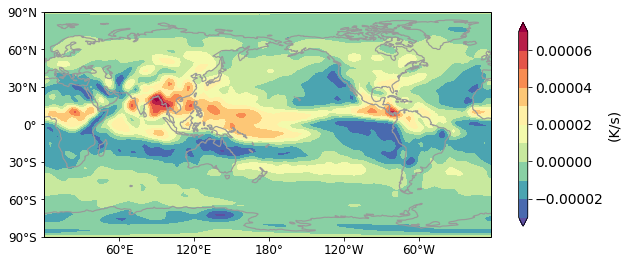

In [23]:
fig5 = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax.coastlines(linewidth=1.2, color=[0.6,0.6,0.6], linestyle='-')

ci=-0.00003; cf=0.000071; cint=0.00001
cs1 = plt.contourf(tt.lon,tt.lat,Q_orig_clim[5,10],np.arange(ci,cf,cint),transform=ccrs.PlateCarree(),cmap='Spectral_r',extend='both')

#plt.title('NCEP-NCAR '+strm+' climatological Q @ '+str1+'hPa',fontsize=15)
ax.set_xticks([-120, -60 ,0, 60, 120])
ax.set_yticks([-90,-60, -30, 0, 30, 60, 90])
ax.tick_params(labelsize=12)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cb = plt.colorbar(cs1, orientation='vertical', shrink = 0.5)
cb.set_label(r"(K/s)", size=14)
cb.ax.tick_params(labelsize=14)

In [14]:
P

<xarray.DataArray 'P' (P: 17)>
array([  10,   20,   30,   50,   70,  100,  150,  200,  250,  300,  400,  500,
        600,  700,  850,  925, 1000], dtype=int32)
Coordinates:
  * P        (P) int32 10 20 30 50 70 100 150 200 250 300 400 500 600 700 ...
Attributes:
    long_name:  Pressure
    gridtype:   0
    units:      mb